
SwapGame
---



Execute the next cell if necessary to install required libraries in your python installation

In [1]:
! python -m pip install --upgrade pip
! pip3 install networkx
! pip3 install numpy
! pip3 install scipy
! pip3 install pandas
! pip3 install matplotlib

zsh:1: command not found: python


Required libraries

In [2]:
import random
import networkx as nx
import numpy as np
import copy
import scipy
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

Social cost

In [3]:
# Computes the social cost of a node in a graph that is interested in specific nodes, using the SUM metric if use_sum is True, and using the MAX metric otherwise
# if the node cannot reach a node it is interested in, the cost is infinite
def social_cost_player(graph,interests,node:int,use_sum=True):
    if not use_sum:
        return social_cost_player_max(graph,interests,node)
    cost = 0
    spl = dict(nx.all_pairs_shortest_path_length(graph))
    if node in interests:
        for ele in interests[node]:
            if node in spl:
                if ele in spl[node]:
                    cost += spl[node][ele]
                else:
                    cost += float('inf')
    return cost

# Computes the social cost of a node in a graph that is interested in specific nodes, using the MAX metric
# if the node cannot reach a node it is interested in, the cost is infinite
def social_cost_player_max(graph,interests,node:int):
    cost = 0
    spl = dict(nx.all_pairs_shortest_path_length(graph))
    if node in interests:
        for ele in interests[node]:
            if node in spl:
                if ele in spl[node]:
                    if cost < spl[node][ele]: 
                        cost = spl[node][ele]
                else:
                    cost = float('inf')
    return cost

# Computes the social cost of graph using the SUM metric if use_sum is True, and using the MAX metric otherwise
# the social cost is equal to the sum of distances between nodes and their interests (communication cost),  
def social_cost_graph(graph,interests,use_sum=True):
    if not use_sum:
        return social_cost_graph_max(graph,interests)
    cost = 0
    for node in graph.nodes():
        cost += social_cost_player(graph, interests, node)
    #cost += nx.number_of_edges(graph)
    return cost

# Computes the social cost of graph using the MAX metric
# the social cost is equal to the sum of distances between nodes and their interests (communication cost),  
# plus the number of bought edges (construction cost) 
def social_cost_graph_max(graph,interests):
    cost = 0
    for node in graph.nodes():
        cost += social_cost_player_max(graph, interests, node)
    #cost += nx.number_of_edges(graph)
    return cost


Random connected graph

In [4]:
"""
Method to generate a random connected graph
The graph is generated by erdos renyi, selecting p to have a high probability of beign connected
Retry as necessary
"""
def random_connected_graph(size:int):
    # when p > (1+epsilon) ln(n)/n, the probability that the graph is connected is high
    graph = nx.erdos_renyi_graph(size,1.01*np.log(size)/size)
    while not nx.is_connected(graph):
        graph = nx.erdos_renyi_graph(size,1.01*np.log(size)/size)
    return graph

Spanning Tree

In [5]:
"""
Method to compute the best spanning tree of a host graph based on the social cost, based on node interests
Return the best graph (tree) and its associated cost, stating from a host graph given as parameter
"""
def best_spanning_tree(graph,interests,use_sum=True):
    min_cost = float('inf')
    st_min = None

    # search spanning tree with lowest social cost
    for st in nx.SpanningTreeIterator(graph):
        cost = social_cost_graph(st,interests,use_sum)
        if cost < min_cost:
            st_min = st.copy()
            min_cost = cost
    
    return (st_min,min_cost)

"""
Method to compute the best spanning tree based on the social cost
Return the best graph (tree) and its associated cost, stating from a complete host graph of number_nodes
"""
def best_spanning_tree_complete(number_nodes,interests,use_sum=True):
    return best_spanning_tree(nx.complete_graph(number_nodes),interests,use_sum)

"""
Method to compute all spanning tree from a host graph provided as parameter
Returns a list of graphs that are actually spanning trees
"""
def all_spanning_trees(graph):
     res = [st for st in nx.SpanningTreeIterator(graph)]
     return res

# replaced with nx version
#def random_spanning_tree(graph):
#    return random.choice(all_spanning_trees(graph))


Graph swap a single edge

In [6]:
"""
Method to update the graph using networkx 
the edge (node,node_to_remove) is deleted
the edge (node,node_to_add) is added
"""
def update_graph(graph,node,node_to_remove,node_to_add):
    graph.remove_edge(node,node_to_remove)
    graph.add_edge(node,node_to_add)
    return graph

Strategies

In [7]:
"""
Turns a digraph into interests for each node : each node's insterests consists of its outgoing neighbors 
in the input directed graph
"""
def get_interests_from_digraph(graph):
    interests = defaultdict(list)
    for u,v in graph.edges(data=False):
        interests[u].append(v)
    return interests

"""
Turns an undirected graph into interests for each node : each node's insterests consists of its neighbors 
in the input graph
"""
def get_interests_from_graph(graph):
    interests = defaultdict(list)
    for u,v in graph.edges(data=False):
        interests[u].append(v)
        interests[v].append(u)
    return interests

"""
method to compute all swap strategies possible for the node for this turn
--> strategies contains all possibilities for edge swap, the edge to be removed 
is a current neighbor of of the node, while the edge to be added involves any node 
that is not a current neighbor of the current node, but present in the host graph
A solution is a 2-tuple (node_to_remove, node_to_add) in the strategy of the node
Return a list of 2-tuples
"""
def get_swap_strategies_available_host(graph,host_graph,node):

    # get all nodes
    neighbors_available = set([i for i in host_graph.neighbors(node)])

    # remove current node and his neighbors
    if node in neighbors_available:
        neighbors_available.remove(node)
    for ele in graph.neighbors(node):
        if ele in neighbors_available:
            neighbors_available.remove(ele)

    # get all strategies available by swap
    solutions = list()

    for node_to_add in neighbors_available:
        for node_to_remove in graph.neighbors(node):
            tup = (node_to_remove,node_to_add)
            solutions.append(tup)
    
    return solutions

"""
Method to improve the current strategy (wrt social cost for the node)
Returns None if no strategy can improve the current one for the node
"""
def improve_strategy(graph, host_graph, interests, node, allow_disconnect: bool, use_sum=True):
    current_cost = social_cost_player(graph,interests,node,use_sum)
    minimal_cost = current_cost
    minimal_strategy = None
    #print(current_cost)

    # browse all solutions (tuples)
    for node_to_remove, node_to_add in get_swap_strategies_available_host( graph, host_graph, node ): 
        
        # update graph
        update_graph(graph,node,node_to_remove,node_to_add)

        # check if the graph is disconneted by this solution 
        # --> avoid this solution only we have not the autorisation to deconnect the graph
        if allow_disconnect == False and nx.is_connected(graph) == False:
            update_graph(graph,node,node_to_add,node_to_remove) # get the initial topology
            continue

        tmp_cost = social_cost_player(graph,interests,node,use_sum)# get social cost
        # check if we find a best strategy
        if tmp_cost < minimal_cost : 
            minimal_cost = tmp_cost
            minimal_strategy = (node_to_remove,node_to_add)

        update_graph(graph,node,node_to_add,node_to_remove) # get the initial topology
    return minimal_strategy

Simulation Core Functions

In [8]:
"""
Method use to let a player improve its social cost if possible
Return true if cost was improved, False otherwise
"""
def play_node(graph,host_graph,interests,node,allow_disconnect,use_sum=True):
    best_strategy = improve_strategy(graph,host_graph,interests,node,allow_disconnect,use_sum)
    if best_strategy is not None:
        node_to_remove = best_strategy[0]
        node_to_add = best_strategy[1]
        update_graph(graph,node,node_to_remove,node_to_add)
        return True
    else:
         return False

"""
Execute one node at random
"""
def run_one_random_node(graph,host_graph,interests,allow_disconnect:bool,use_sum=True):
    node = random.choice(range(graph.number_of_nodes()))
    play_node(graph,host_graph,interests,node,allow_disconnect,use_sum)

"""
Execute all nodes in a random order
"""
def run_one_random_round(graph,host_graph,interests,allow_disconnect:bool,use_sum=True):
    nodes = np.random.permutation(np.array(range(graph.number_of_nodes())))
    for node in nodes:
        play_node(graph,host_graph,interests,node,allow_disconnect,use_sum)

"""
Method to check if there is a convergence in the game
Returns true if the system has converged (no node can improve its cost)
Returns false otherwise
"""
def has_converged(graph,host_graph,interests,allow_disconnect,use_sum=True):
    for node in graph.nodes() : 
        if improve_strategy(graph,host_graph,interests,node,allow_disconnect,use_sum) is not None:
            return False
    return True
    
"""
Method to compute the best spanning tree, min equilibrium, max equilibrium of a host graph 
based on the social cost, based on node interests
Return the best tree, min eq, max eq and their associated cost 
stating from a host graph given as parameter
"""
def best_spanning_tree_equilibria(graph,interests,allow_disconnect=False,use_sum=True):
    min_cost = float('inf')
    min_eq_cost = float('inf')
    max_eq_cost = float('0')
    st_min = None
    st_eq_min = None
    st_eq_max = None

    # search spanning tree with lowest social cost
    for st in nx.SpanningTreeIterator(graph):
        cost = social_cost_graph(st,interests,use_sum)
        if cost < min_cost:
            st_min = st.copy()
            min_cost = cost
        if has_converged(st,graph,interests,allow_disconnect,use_sum=True):
            if cost < min_eq_cost:
                st_eq_min = st.copy()
                min_eq_cost = cost
            if cost > max_eq_cost:
                st_eq_max = st.copy()
                max_eq_cost = cost
    return (st_min,min_cost,st_eq_min,min_eq_cost,st_eq_max,max_eq_cost)

"""
Method to run a single simulation
takes as input:
- initial topology graph (n nodes)
- host graph (n nodes)
- interests graph (<= n nodes graph)
- limit : maximum number of rounds
- ability to disconnect
Returns:
- a 3-tuple with
    - the final graph (equilibrium graph if the associated number is less than limit)
    - the social cost of the final graph
    - a number
        - a positive (or zero) number if convergence is achieved within limit rounds, this number is the number of rounds to reach convergence
        - a -1 if no convergence is reached before limit rounds are run
"""
def run_once(initial_graph, host_graph, interests_graph, limit:int, allow_disconnect:bool, use_sum=True):

    graph = copy.deepcopy(initial_graph)
    interests = get_interests_from_digraph(interests_graph)

    nb_rounds = 0 
    if has_converged(graph, host_graph, interests, allow_disconnect,use_sum): 
        return (graph,social_cost_graph(graph,interests,use_sum),0)
    else:
        while nb_rounds <= limit:
            run_one_random_node(graph,host_graph,interests,allow_disconnect,use_sum)
            nb_rounds += 1
            if has_converged(graph,host_graph,interests,allow_disconnect,use_sum):
                return (graph,social_cost_graph(graph,interests,use_sum),nb_rounds)
        return (graph,social_cost_graph(graph,interests,use_sum),-1)

"""
This methods runs the simulation how_many times with the same parameters
Returns a list of 3-tuple results
"""
def run_several(initial_graph, host_graph, interests_graph, how_many:int, limit:int, allow_disconnect:bool, use_sum=True):
    res = list()
    for i in range(how_many):
        r = run_once(initial_graph,host_graph,interests_graph,limit,allow_disconnect,use_sum)
        res.append(r)
    return res
        
"""
This method runs one simulation several times and reports:
- the best social cost tree  
- two numpy arrays:
    - costs obtained
    - times obtained
"""
def run_one_simulation(host_graph,interests_graph,nb_initial:int,how_many:int,limit:int,use_sum=True,allow_disconnect=False,save_graphs=False):
    
    #print(f"host graph: {host_graph.edges()}")
    if(save_graphs):
        nx.draw(host_graph,with_labels=True)
        plt.savefig("host_graph.png")
        plt.clf()
    
    #print(f"interests graph: {interests_graph.edges()}")
    if(save_graphs):
        nx.draw(interests_graph,with_labels=True)
        plt.savefig("interests_graph.png")
        plt.clf()
    
    interests = get_interests_from_digraph(interests_graph)
    
    st = best_spanning_tree(host_graph,interests,use_sum)
    if(save_graphs):
        nx.draw(st[0],with_labels=True)
        plt.savefig("best_spanning_tree.png")
        plt.clf()
    print(f"Best spanning tree cost: {st[1]}")

    costs = list()
    times = list()
    
    for sample in range(nb_initial):
        initial_graph = nx.random_spanning_tree(host_graph)
    
        res = run_several(initial_graph,host_graph,interests_graph,how_many,limit,allow_disconnect,use_sum)
        
        i = 0
        for r in res:
            if(save_graphs):
                nx.draw(r[0],with_labels=True)
                plt.savefig(f"res_{sample}_{i}_graph.png")
                plt.clf()
            costs.append(r[1])
            times.append(r[2])
            #print(f"Output {sample}-{i} cost:{r[1]} time:{r[2]}")
            i += 1

    return (st[1],costs,times)

"""
This method runs one simulation several times and reports:  
- two numpy arrays:
    - costs obtained
    - times obtained
"""
def run_one_simulation_nb(host_graph,interests_graph,nb_initial:int,how_many:int,limit:int,use_sum=True,allow_disconnect=False,save_graphs=False):
    interests = get_interests_from_digraph(interests_graph)
    costs = list()
    times = list()
    
    for sample in range(nb_initial):
        initial_graph = nx.random_spanning_tree(host_graph)
    
        res = run_several(initial_graph,host_graph,interests_graph,how_many,limit,allow_disconnect,use_sum)
        
        i = 0
        for r in res:
            costs.append(r[1])
            times.append(r[2])
            i += 1

    return (costs,times)

"""
This method runs one simulation campaign, with a given host graph, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""    
def run_campaign(host_graph,allow_disconnect_p=False,use_sum_p=True):
    how_many_per_interest_graph_and_initial_tree = 10 
    nb_initial_tree = 10
    nb_interest_graph = 10
    limit = 1000

    df_optimal = pd.DataFrame()
    df_min_cost = pd.DataFrame()
    df_max_cost = pd.DataFrame()
    df_cost = pd.DataFrame()
    df_time = pd.DataFrame()

    for p in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        optimals = list()
        min_costs = list()
        max_costs = list()
        costs = list()
        times = list()
        for i in range(nb_interest_graph):
            interests_graph = nx.erdos_renyi_graph(host_graph.number_of_nodes(),p,directed=True)
            res = run_one_simulation(host_graph,interests_graph,nb_initial_tree,how_many_per_interest_graph_and_initial_tree,limit,allow_disconnect=allow_disconnect_p,use_sum=use_sum_p)
            optimals.append(res[0])
            min_costs.append(min(res[1]))
            max_costs.append(max(res[1]))
            costs.extend(res[1])
            times.extend(res[2])
        df_optimal[p] = optimals
        df_min_cost[p] = min_costs
        df_max_cost[p] = max_costs
        df_cost[p] = costs
        df_time[p] = times
    return (df_optimal,df_cost,df_time,df_min_cost,df_max_cost)

"""
This method runs one simulation campaign, with the pertersen graph as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""    
def run_campaign_petersen(allow_disconnect=False,use_sum=True):
    return run_campaign(nx.petersen_graph(),allow_disconnect,use_sum)

"""
This method runs one simulation campaign, with a complete graph of size nodes as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_complete(size:int,allow_disconnect=False,use_sum=True):
    return run_campaign(nx.complete_graph(size),allow_disconnect,use_sum)

"""
This method runs one simulation campaign, with a random graph of size nodes as a host graph, 
where each (undirected) edge has probability p, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_random(size:int,p:float,allow_disconnect=False,use_sum=True):
    return run_campaign(nx.erdos_renyi_graph(size,p),allow_disconnect,use_sum)

"""
This method runs howmany simulations campaign, with a random graph of size nodes as a host graph (different in each campaign), 
where each (undirected) edge has probability p, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_random_multi(size:int,p:float,how_many:int,allow_disconnect=False,use_sum=True):
    l_df_optimal = list()
    l_df_cost = list()
    l_df_time = list()
    l_df_min_cost = list()
    l_df_max_cost = list()
    for i in range(how_many):
        df_optimal,df_cost,df_time,df_min_cost,df_max_cost = run_campaign(nx.erdos_renyi_graph(size,p),allow_disconnect,use_sum)
        l_df_optimal.append(df_optimal)
        l_df_cost.append(df_cost)
        l_df_time.append(df_time)
        l_df_min_cost.append(df_min_cost)
        l_df_max_cost.append(df_max_cost)
    return(pd.concat(l_df_optimal, ignore_index = True),pd.concat(l_df_cost, ignore_index = True),pd.concat(l_df_time, ignore_index = True),pd.concat(l_df_min_cost, ignore_index = True),pd.concat(l_df_max_cost, ignore_index = True))    

"""
This method runs howmany simulations campaign, with a random connected graph of size nodes as a host graph (different in each campaign), 
varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_random_multi_connected(size:int,how_many:int,allow_disconnect=False,use_sum=True):
    l_df_optimal = list()
    l_df_cost = list()
    l_df_time = list()
    l_df_min_cost = list()
    l_df_max_cost = list()
    for i in range(how_many):
        df_optimal,df_cost,df_time,df_min_cost,df_max_cost = run_campaign(random_connected_graph(size),allow_disconnect,use_sum)
        l_df_optimal.append(df_optimal)
        l_df_cost.append(df_cost)
        l_df_time.append(df_time)
        l_df_min_cost.append(df_min_cost)
        l_df_max_cost.append(df_max_cost)
    return(pd.concat(l_df_optimal, ignore_index = True),pd.concat(l_df_cost, ignore_index = True),pd.concat(l_df_time, ignore_index = True),pd.concat(l_df_min_cost, ignore_index = True),pd.concat(l_df_max_cost, ignore_index = True))    

"""
This method runs one simulation campaign, with a ring graph of size nodes as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_ring(size:int,allow_disconnect=False,use_sum=True):
    return run_campaign(nx.cycle_graph(size),allow_disconnect,use_sum)


# Diameter computations
Alternative version of the previous functions, where the optimal spanning tree is NOT calculated, but where the diameters of the host graph, the interest graph, and the equilibrium graphs are reported.

In [41]:
def lcc_diameter(g):
    lcc = max(nx.connected_components(g.to_undirected()), key=len)
    lcc_g = g.subgraph(lcc).copy().to_undirected()
    return nx.diameter(lcc_g)

"""
This method runs one simulation several times and reports:
- the diameter of the host graph
- the diameter of the interests graph
- three numpy arrays:
    - diameters of equilibrium graphs obtained
    - costs of equilibrium graphs obtained
    - times to reach equilibrium obtained
"""
def run_one_simulation_diam(host_graph,interests_graph,nb_initial:int,how_many:int,limit:int,use_sum=True,allow_disconnect=False,save_graphs=False):
    interests = get_interests_from_digraph(interests_graph)
    costs = list()
    times = list()
    host_diameter = lcc_diameter(host_graph)
    interest_diameter = lcc_diameter(interests_graph)
    equilibrium_diameters = list()
    
    for sample in range(nb_initial):
        initial_graph = nx.random_spanning_tree(host_graph)
    
        res = run_several(initial_graph,host_graph,interests_graph,how_many,limit,allow_disconnect,use_sum)
        
        i = 0
        for r in res:
            equilibrium_diameters.append(lcc_diameter(r[0]))
            costs.append(r[1])
            times.append(r[2])
            i += 1

    return ([host_diameter],[interest_diameter],equilibrium_diameters,costs,times)

"""
This method runs one simulation campaign, with a given host graph, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost

"""    
def run_campaign_diam(host_graph,allow_disconnect_p=False,use_sum_p=True):
    how_many_per_interest_graph_and_initial_tree = 10 
    nb_initial_tree = 10
    nb_interest_graph = 10
    limit = 1000

    host_diameter = nx.diameter(host_graph)
    
    df_cost = pd.DataFrame()
    df_time = pd.DataFrame()
    df_host_diameters = pd.DataFrame()
    df_interests_diameters = pd.DataFrame()
    df_equilibrium_diameters = pd.DataFrame()

    for p in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        costs = list()
        times = list()
        h_diameters = list()
        i_diameters = list()
        e_diameters = list()
        
        for i in range(nb_interest_graph):
            interests_graph = nx.erdos_renyi_graph(host_graph.number_of_nodes(),p,directed=True)
            res = run_one_simulation_diam(host_graph,interests_graph,nb_initial_tree,how_many_per_interest_graph_and_initial_tree,limit,allow_disconnect=allow_disconnect_p,use_sum=use_sum_p)
            h_diameters.extend(res[0])
            i_diameters.extend(res[1])
            e_diameters.extend(res[2])
            costs.extend(res[3])
            times.extend(res[4])
        
        df_host_diameters[p] = h_diameters
        df_interests_diameters[p] = i_diameters
        df_equilibrium_diameters[p] = e_diameters
        df_cost[p] = costs
        df_time[p] = times
    return (df_host_diameters,df_interests_diameters,df_equilibrium_diameters, df_cost,df_time)

"""
This method runs one simulation campaign, with the pertersen graph as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost
"""    
def run_campaign_petersen_diam(allow_disconnect=False,use_sum=True):
    return run_campaign_diam(nx.petersen_graph(),allow_disconnect,use_sum)

"""
This method runs one simulation campaign, with a complete graph of size nodes as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost
"""
def run_campaign_complete_diam(size:int,allow_disconnect=False,use_sum=True):
    return run_campaign_diam(nx.complete_graph(size),allow_disconnect,use_sum)

"""
This method runs one simulation campaign, with a random graph of size nodes as a host graph, 
where each (undirected) edge has probability p, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost
"""
def run_campaign_random_diam(size:int,p:float,allow_disconnect=False,use_sum=True):
    return run_campaign_diam(nx.erdos_renyi_graph(size,p),allow_disconnect,use_sum)

"""
This method runs howmany simulations campaign, with a random graph of size nodes as a host graph (different in each campaign), 
where each (undirected) edge has probability p, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost
"""
def run_campaign_random_multi_diam(size:int,p:float,how_many:int,allow_disconnect=False,use_sum=True):
    l_df_host_diameters = list()
    l_df_interests_diameters = list()
    l_df_equilibrium_diameters = list()
    l_df_cost = list()
    l_df_time = list()
    for i in range(how_many):
        df_host_diameters, df_interests_diameters, df_equilibrium_diameters, df_cost, df_time = run_campaign(nx.erdos_renyi_graph(size,p),allow_disconnect,use_sum)
        l_df_host_diameters.append(df_host_diameters)
        l_df_interests_diameters.append(df_interests_diameters)
        l_df_equilibrium_diameters.append(df_equilibrium_diameters)
        l_df_cost.append(df_cost)
        l_df_time.append(df_time)
    return(pd.concat(l_df_host_diameters, ignore_index = True),
           pd.concat(l_df_interests_diameters, ignore_index = True),
           pd.concat(l_df_equilibrium_diameters, ignore_index = True),
           pd.concat(l_df_cost, ignore_index = True),
           pd.concat(l_df_time, ignore_index = True))    

"""
This method runs howmany simulations campaign, with a random connected graph of size nodes as a host graph (different in each campaign), 
varying the probability of existence of each interest
It returns five dataframes:
- the cost of the optimal social cost tree
- the minimum cost of the equilibrium social cost
- the maximum cost of the equilibrium social cost
- the cost of the equilibrium social cost
- the time to reach the equilibrium social cost
"""
def run_campaign_random_multi_connected_diam(size:int,how_many:int,allow_disconnect=False,use_sum=True):
    l_df_host_diameters = pd.DataFrame()
    l_df_interests_diameters = pd.DataFrame()
    l_df_equilibrium_diameters = pd.DataFrame()
    l_df_cost = pd.DataFrame()
    l_df_time = pd.DataFrame()
    for i in range(how_many):
        df_host_diameters, df_interests_diameters, df_equilibrium_diameters, df_cost, df_time = run_campaign_diam(random_connected_graph(size),allow_disconnect,use_sum)
        l_df_host_diameters = pd.concat([l_df_host_diameters,df_host_diameters])
        l_df_interests_diameters = pd.concat([l_df_interests_diameters,df_interests_diameters])
        l_df_equilibrium_diameters = pd.concat([l_df_equilibrium_diameters,df_equilibrium_diameters])
        l_df_cost = pd.concat([l_df_cost,df_cost])
        l_df_time = pd.concat([l_df_time,df_time])
        
    return(l_df_host_diameters,
           l_df_interests_diameters, 
           l_df_equilibrium_diameters, 
           l_df_cost, 
           l_df_time)    

"""
This method runs one simulation campaign, with a ring graph of size nodes as a host graph, varying the probability of existence of each interest
It returns five dataframes:
- the diameters of the host graph (should be all equals)
- the diameters of the interests graphs
- the diameters of the equilibrium graphs
- the costs of the equilibrium social cost
- the times to reach the equilibrium social cost
"""
def run_campaign_ring_diam(size:int,allow_disconnect=False,use_sum=True):
    return run_campaign_diam(nx.cycle_graph(size),allow_disconnect,use_sum)


# Run Diameter Simulations (no PoA/PoS)
(about 2h per cell)

In [62]:
# RANDOM diameter experiments

# MAX metric connected experiments
df_host_diameters_c_m,df_interests_diameters_c_m,df_equilibrium_diameters_c_m, df_cost_c_m, df_time_c_m = run_campaign_random_multi_connected_diam(5,10,allow_disconnect=False,use_sum=False)
df_host_diameters_c_m.to_csv("df_host_diameters_c_m.csv")
df_interests_diameters_c_m.to_csv("df_interests_diameters_c_m.csv")
df_equilibrium_diameters_c_m.to_csv("df_equilibrium_diameters_c_m.csv")
df_cost_c_m.to_csv("df_cost_c_m.csv")
df_time_c_m.to_csv("df_time_c_m.csv")
# MAX metric disconnected experiments
df_host_diameters_d_m,df_interests_diameters_d_m,df_equilibrium_diameters_d_m, df_cost_d_m, df_time_d_m = run_campaign_random_multi_connected_diam(5,10,allow_disconnect=True,use_sum=False)
df_host_diameters_d_m.to_csv("df_host_diameters_d_m.csv")
df_interests_diameters_d_m.to_csv("df_interests_diameters_d_m.csv")
df_equilibrium_diameters_d_m.to_csv("df_equilibrium_diameters_d_m.csv")
df_cost_d_m.to_csv("df_cost_d_m.csv")
df_time_d_m.to_csv("df_time_d_m.csv")
# SUM metric connected experiments
df_host_diameters_c_s,df_interests_diameters_c_s,df_equilibrium_diameters_c_s, df_cost_c_s,df_time_c_s = run_campaign_random_multi_connected_diam(5,10,allow_disconnect=False,use_sum=True)
df_host_diameters_c_s.to_csv("df_host_diameters_c_s.csv")
df_interests_diameters_c_s.to_csv("df_interests_diameters_c_s.csv")
df_equilibrium_diameters_c_s.to_csv("df_equilibrium_diameters_c_s.csv")
df_cost_c_s.to_csv("df_cost_c_s.csv")
df_time_c_s.to_csv("df_time_c_s.csv")
# SUM metric disconnected experiments
df_host_diameters_d_s,df_interests_diameters_d_s,df_equilibrium_diameters_d_s, df_cost_d_s,df_time_d_s = run_campaign_random_multi_connected_diam(5,10,allow_disconnect=True,use_sum=True)
df_host_diameters_d_s.to_csv("df_host_diameters_d_s.csv")
df_interests_diameters_d_s.to_csv("df_interests_diameters_d_s.csv")
df_equilibrium_diameters_d_s.to_csv("df_equilibrium_diameters_d_s.csv")
df_cost_d_s.to_csv("df_cost_d_s.csv")
df_time_d_s.to_csv("df_time_d_s.csv")


In [60]:
#RING diameter experiments

# MAX metric connected experiments
df_host_diameters_c_m,df_interests_diameters_c_m,df_equilibrium_diameters_c_m, df_cost_c_m, df_time_c_m = run_campaign_ring_diam(20,allow_disconnect=False,use_sum=False)
df_host_diameters_c_m.to_csv("df_host_diameters_c_m.csv")
df_interests_diameters_c_m.to_csv("df_interests_diameters_c_m.csv")
df_equilibrium_diameters_c_m.to_csv("df_equilibrium_diameters_c_m.csv")
df_cost_c_m.to_csv("df_cost_c_m.csv")
df_time_c_m.to_csv("df_time_c_m.csv")
# MAX metric disconnected experiments
df_host_diameters_d_m,df_interests_diameters_d_m,df_equilibrium_diameters_d_m, df_cost_d_m, df_time_d_m = run_campaign_ring_diam(20,allow_disconnect=True,use_sum=False)
df_host_diameters_d_m.to_csv("df_host_diameters_d_m.csv")
df_interests_diameters_d_m.to_csv("df_interests_diameters_d_m.csv")
df_equilibrium_diameters_d_m.to_csv("df_equilibrium_diameters_d_m.csv")
df_cost_d_m.to_csv("df_cost_d_m.csv")
df_time_d_m.to_csv("df_time_d_m.csv")
# SUM metric connected experiments
df_host_diameters_c_s,df_interests_diameters_c_s,df_equilibrium_diameters_c_s, df_cost_c_s,df_time_c_s = run_campaign_ring_diam(20,allow_disconnect=False,use_sum=True)
df_host_diameters_c_s.to_csv("df_host_diameters_c_s.csv")
df_interests_diameters_c_s.to_csv("df_interests_diameters_c_s.csv")
df_equilibrium_diameters_c_s.to_csv("df_equilibrium_diameters_c_s.csv")
df_cost_c_s.to_csv("df_cost_c_s.csv")
df_time_c_s.to_csv("df_time_c_s.csv")
# SUM metric disconnected experiments
df_host_diameters_d_s,df_interests_diameters_d_s,df_equilibrium_diameters_d_s, df_cost_d_s,df_time_d_s = run_campaign_ring_diam(20,allow_disconnect=True,use_sum=True)
df_host_diameters_d_s.to_csv("df_host_diameters_d_s.csv")
df_interests_diameters_d_s.to_csv("df_interests_diameters_d_s.csv")
df_equilibrium_diameters_d_s.to_csv("df_equilibrium_diameters_d_s.csv")
df_cost_d_s.to_csv("df_cost_d_s.csv")
df_time_d_s.to_csv("df_time_d_s.csv")

In [58]:
#COMPLETE diameter experiments

# MAX metric connected experiments
df_host_diameters_c_m,df_interests_diameters_c_m,df_equilibrium_diameters_c_m, df_cost_c_m, df_time_c_m = run_campaign_complete_diam(5,allow_disconnect=False,use_sum=False)
df_host_diameters_c_m.to_csv("df_host_diameters_c_m.csv")
df_interests_diameters_c_m.to_csv("df_interests_diameters_c_m.csv")
df_equilibrium_diameters_c_m.to_csv("df_equilibrium_diameters_c_m.csv")
df_cost_c_m.to_csv("df_cost_c_m.csv")
df_time_c_m.to_csv("df_time_c_m.csv")
# MAX metric disconnected experiments
df_host_diameters_d_m,df_interests_diameters_d_m,df_equilibrium_diameters_d_m, df_cost_d_m, df_time_d_m = run_campaign_complete_diam(5,allow_disconnect=True,use_sum=False)
df_host_diameters_d_m.to_csv("df_host_diameters_d_m.csv")
df_interests_diameters_d_m.to_csv("df_interests_diameters_d_m.csv")
df_equilibrium_diameters_d_m.to_csv("df_equilibrium_diameters_d_m.csv")
df_cost_d_m.to_csv("df_cost_d_m.csv")
df_time_d_m.to_csv("df_time_d_m.csv")
# SUM metric connected experiments
df_host_diameters_c_s,df_interests_diameters_c_s,df_equilibrium_diameters_c_s, df_cost_c_s,df_time_c_s = run_campaign_complete_diam(5,allow_disconnect=False,use_sum=True)
df_host_diameters_c_s.to_csv("df_host_diameters_c_s.csv")
df_interests_diameters_c_s.to_csv("df_interests_diameters_c_s.csv")
df_equilibrium_diameters_c_s.to_csv("df_equilibrium_diameters_c_s.csv")
df_cost_c_s.to_csv("df_cost_c_s.csv")
df_time_c_s.to_csv("df_time_c_s.csv")
# SUM metric disconnected experiments
df_host_diameters_d_s,df_interests_diameters_d_s,df_equilibrium_diameters_d_s, df_cost_d_s,df_time_d_s = run_campaign_complete_diam(5,allow_disconnect=True,use_sum=True)
df_host_diameters_d_s.to_csv("df_host_diameters_d_s.csv")
df_interests_diameters_d_s.to_csv("df_interests_diameters_d_s.csv")
df_equilibrium_diameters_d_s.to_csv("df_equilibrium_diameters_d_s.csv")
df_cost_d_s.to_csv("df_cost_d_s.csv")
df_time_d_s.to_csv("df_time_d_s.csv")


In [52]:
#PETERSEN diameter experiments

# MAX metric connected experiments
df_host_diameters_c_m,df_interests_diameters_c_m,df_equilibrium_diameters_c_m, df_cost_c_m, df_time_c_m = run_campaign_petersen_diam(allow_disconnect=False,use_sum=False)
df_host_diameters_c_m.to_csv("df_host_diameters_c_m.csv")
df_interests_diameters_c_m.to_csv("df_interests_diameters_c_m.csv")
df_equilibrium_diameters_c_m.to_csv("df_equilibrium_diameters_c_m.csv")
df_cost_c_m.to_csv("df_cost_c_m.csv")
df_time_c_m.to_csv("df_time_c_m.csv")
# MAX metric disconnected experiments
df_host_diameters_d_m,df_interests_diameters_d_m,df_equilibrium_diameters_d_m, df_cost_d_m, df_time_d_m = run_campaign_petersen_diam(allow_disconnect=True,use_sum=False)
df_host_diameters_d_m.to_csv("df_host_diameters_d_m.csv")
df_interests_diameters_d_m.to_csv("df_interests_diameters_d_m.csv")
df_equilibrium_diameters_d_m.to_csv("df_equilibrium_diameters_d_m.csv")
df_cost_d_m.to_csv("df_cost_d_m.csv")
df_time_d_m.to_csv("df_time_d_m.csv")
# SUM metric connected experiments
df_host_diameters_c_s,df_interests_diameters_c_s,df_equilibrium_diameters_c_s, df_cost_c_s,df_time_c_s = run_campaign_petersen_diam(allow_disconnect=False,use_sum=True)
df_host_diameters_c_s.to_csv("df_host_diameters_c_s.csv")
df_interests_diameters_c_s.to_csv("df_interests_diameters_c_s.csv")
df_equilibrium_diameters_c_s.to_csv("df_equilibrium_diameters_c_s.csv")
df_cost_c_s.to_csv("df_cost_c_s.csv")
df_time_c_s.to_csv("df_time_c_s.csv")
# SUM metric disconnected experiments
df_host_diameters_d_s,df_interests_diameters_d_s,df_equilibrium_diameters_d_s, df_cost_d_s,df_time_d_s = run_campaign_petersen_diam(allow_disconnect=True,use_sum=True)
df_host_diameters_d_s.to_csv("df_host_diameters_d_s.csv")
df_interests_diameters_d_s.to_csv("df_interests_diameters_d_s.csv")
df_equilibrium_diameters_d_s.to_csv("df_equilibrium_diameters_d_s.csv")
df_cost_d_s.to_csv("df_cost_d_s.csv")
df_time_d_s.to_csv("df_time_d_s.csv")

# Run PoA/PoS Simulations (no diameter computations)
(from 30 seconds to 20+ hours, the sparser the graph, the faster)

In [ ]:
# SUM metric connected experiments
df_optimal_c_s, df_cost_c_s, df_time_c_s, df_min_cost_c_s, df_max_cost_c_s = run_campaign_random_multi_connected(10,10,allow_disconnect=False,use_sum=True)
df_optimal_c_s.to_csv("df_optimal_c_s.csv")
df_min_cost_c_s.to_csv("df_min_cost_c_s.csv")
df_max_cost_c_s.to_csv("df_max_cost_c_s.csv")
df_cost_c_s.to_csv("df_cost_c_s.csv")
df_time_c_s.to_csv("df_time_c_s.csv")

In [ ]:

# SUM metric disconnected experiments
df_optimal_d_s, df_cost_d_s, df_time_d_s, df_min_cost_d_s, df_max_cost_d_s = run_campaign_random_multi_connected(10,10,allow_disconnect=True,use_sum=True)
df_optimal_d_s.to_csv("df_optimal_d_s.csv")
df_min_cost_d_s.to_csv("df_min_cost_d_s.csv")
df_max_cost_d_s.to_csv("df_max_cost_d_s.csv")
df_cost_d_s.to_csv("df_cost_d_s.csv")
df_time_d_s.to_csv("df_time_d_s.csv")

In [ ]:

# MAX metric connected experiments
df_optimal_c_m, df_cost_c_m, df_time_c_m, df_min_cost_c_m, df_max_cost_c_m = run_campaign_random_multi_connected(10,10,allow_disconnect=False,use_sum=False)
df_optimal_c_m.to_csv("df_optimal_c_m.csv")
df_min_cost_c_m.to_csv("df_min_cost_c_m.csv")
df_max_cost_c_m.to_csv("df_max_cost_c_m.csv")
df_cost_c_m.to_csv("df_cost_c_m.csv")
df_time_c_m.to_csv("df_time_c_m.csv")

In [ ]:

# MAX metric disconnected experiments
df_optimal_d_m, df_cost_d_m, df_time_d_m, df_min_cost_d_m, df_max_cost_d_m = run_campaign_random_multi_connected(10,10,allow_disconnect=True,use_sum=False)
df_optimal_d_m.to_csv("df_optimal_d_m.csv")
df_min_cost_d_m.to_csv("df_min_cost_d_m.csv")
df_max_cost_d_m.to_csv("df_max_cost_d_m.csv")
df_cost_d_m.to_csv("df_cost_d_m.csv")
df_time_d_m.to_csv("df_time_d_m.csv")

In [ ]:
# Reload past data to regenerate graphs
def read_csv_custom(filename):
     res = pd.read_csv(filename,header=0,index_col=0)
     res.columns = res.columns.astype(float)
     return res

df_optimal_c_s = read_csv_custom("df_optimal_c_s.csv")
df_min_cost_c_s = read_csv_custom("df_min_cost_c_s.csv")
df_max_cost_c_s = read_csv_custom("df_max_cost_c_s.csv")
df_cost_c_s = read_csv_custom("df_cost_c_s.csv")
df_time_c_s = read_csv_custom("df_time_c_s.csv")

df_optimal_d_s = read_csv_custom("df_optimal_d_s.csv")
df_min_cost_d_s = read_csv_custom("df_min_cost_d_s.csv")
df_max_cost_d_s = read_csv_custom("df_max_cost_d_s.csv")
df_cost_d_s = read_csv_custom("df_cost_d_s.csv")
df_time_d_s = read_csv_custom("df_time_d_s.csv")

df_optimal_c_m = read_csv_custom("df_optimal_c_m.csv")
df_min_cost_c_m = read_csv_custom("df_min_cost_c_m.csv")
df_max_cost_c_m = read_csv_custom("df_max_cost_c_m.csv")
df_cost_c_m = read_csv_custom("df_cost_c_m.csv")
df_time_c_m = read_csv_custom("df_time_c_m.csv")

df_optimal_d_m = read_csv_custom("df_optimal_d_m.csv")
df_min_cost_d_m = read_csv_custom("df_min_cost_d_m.csv")
df_max_cost_d_m = read_csv_custom("df_max_cost_d_m.csv")
df_cost_d_m = read_csv_custom("df_cost_d_m.csv")
df_time_d_m = read_csv_custom("df_time_d_m.csv")

# Define functions to draw the figures

In [18]:
"""
This method produces a figure where the ratio of infinite equilibrium is displayed, given simulation results
"""
def draw_figure_infinite(df_metric, title, metric):
    plt.clf()
    fig, ax = plt.subplots()
    df_plot = pd.DataFrame()
    for p in [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]:
        df_plot.insert(0,p,1.0-df_metric.groupby(np.isinf(df_metric[p])).count()[1]/len(df_metric[p]))
    df_plot.mean(0).plot(label='selfish')
    plt.legend()
    ax.set_xlabel(r'$p$ in $G(n,p)$', fontsize=15)
    ax.set_ylabel(metric, fontsize=15)
    ax.set_title(title)
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"{title}_{metric}.png")
    plt.show()
    

"""
This method produces a figure where the price of anarchy and stability are displayed, given optimal spanning tree, minimun cost simulations, and maximum cost simulations
"""
def draw_figures_price(df_optimal, df_min_cost, df_max_cost, title, metric):
    plt.clf()
    fig, ax = plt.subplots()
    df_price_anarchy = pd.DataFrame(df_optimal / df_max_cost)
    df_price_stability = pd.DataFrame(df_optimal / df_min_cost)
    df_price_anarchy.mean(0).plot(label='Price of Anarchy')
    df_price_stability.mean(0).plot(label="Price of Stability")
    plt.legend()
    ax.set_xlabel(r'$p$ in $G(n,p)$', fontsize=15)
    ax.set_ylabel(metric, fontsize=15)
    ax.set_title(title)
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"{title}_{metric}.png")
    plt.show()

"""
This method produces a figure (cost, time) from a single dataset, given optimal spanning tree, cost or time simulation
"""
def draw_figure(df_optimal,df_metric,label_p,title,metric):
    plt.clf()
    fig, ax = plt.subplots()
    df_optimal.mean(0).plot(label='optimal')
    df_metric.mean(0).plot(label=label_p)
    plt.legend()
    ax.set_xlabel(r'$p$ in $G(n,p)$', fontsize=15)
    ax.set_ylabel(metric, fontsize=15)
    ax.set_title(title)
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"{title}_{metric}.png")
    plt.show()
    

"""
This method produces a figure (cost, time) from multiple datasets, given optimal spanning tree, cost or time simulations
"""
def draw_figures(d_df_metric,title,metric):
    plt.clf()
    fig, ax = plt.subplots()
    for l in d_df_metric:
        d_df_metric[l].mean(0).plot(label=l)
    plt.legend()
    ax.set_xlabel(r'$p$ in $G(n,p)$', fontsize=15)
    ax.set_ylabel(metric, fontsize=15)
    ax.set_title(title)
    ax.grid(True)
    fig.tight_layout()
    plt.savefig(f"{title}_{metric}.png")
    plt.show()


Actually draw the figures

<Figure size 640x480 with 0 Axes>

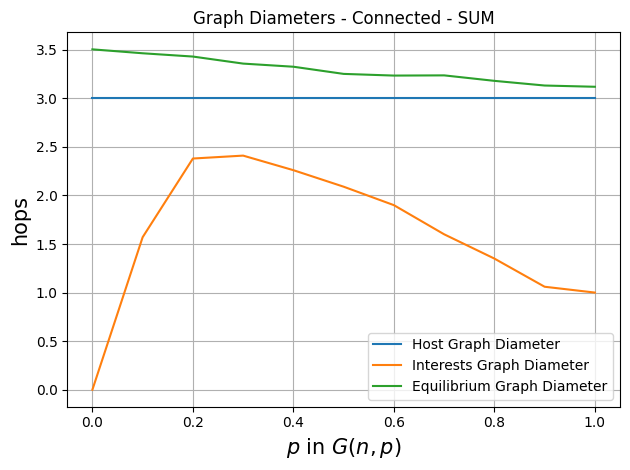

<Figure size 640x480 with 0 Axes>

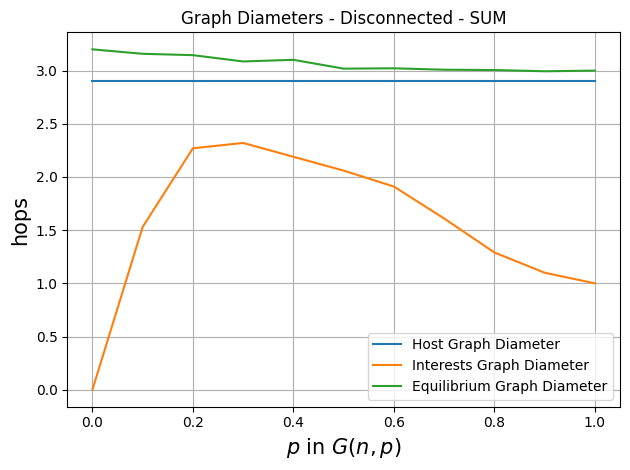

<Figure size 640x480 with 0 Axes>

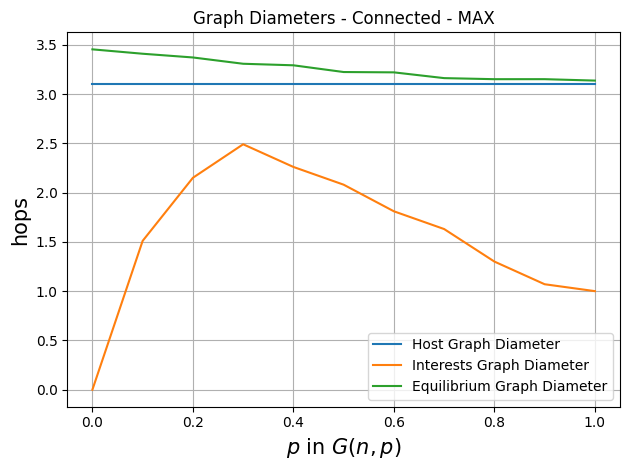

<Figure size 640x480 with 0 Axes>

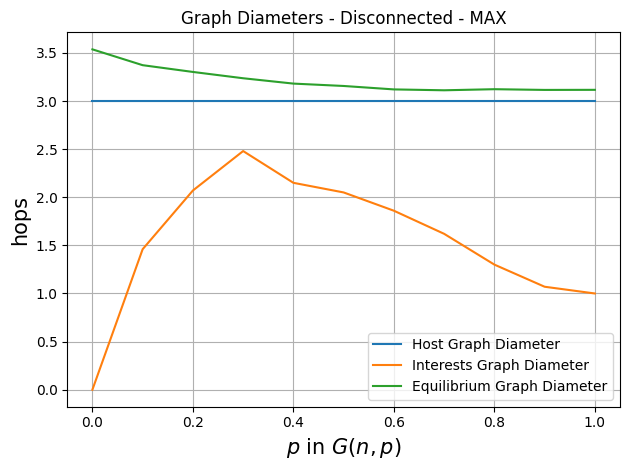

<Figure size 640x480 with 0 Axes>

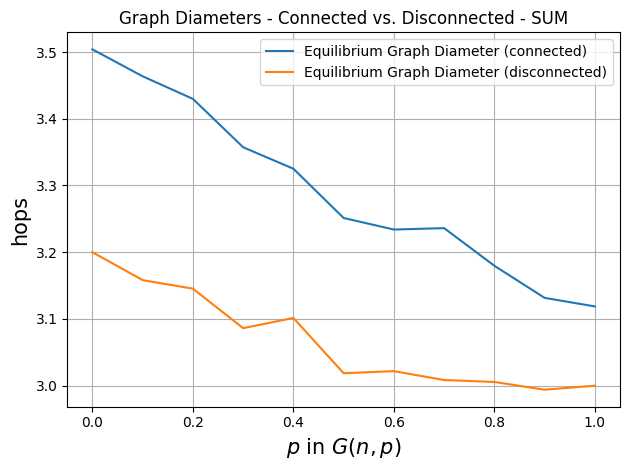

<Figure size 640x480 with 0 Axes>

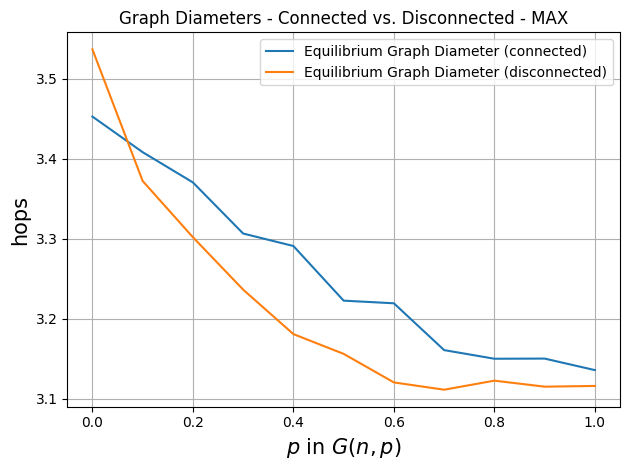

In [63]:
#SUM and #MAX Diameter figures
draw_figures(dict({'Host Graph Diameter':df_host_diameters_c_s,'Interests Graph Diameter':df_interests_diameters_c_s,'Equilibrium Graph Diameter':df_equilibrium_diameters_c_s}),title='Graph Diameters - Connected - SUM',metric='hops')
draw_figures(dict({'Host Graph Diameter':df_host_diameters_d_s,'Interests Graph Diameter':df_interests_diameters_d_s,'Equilibrium Graph Diameter':df_equilibrium_diameters_d_s}),title='Graph Diameters - Disconnected - SUM',metric='hops')
draw_figures(dict({'Host Graph Diameter':df_host_diameters_c_m,'Interests Graph Diameter':df_interests_diameters_c_m,'Equilibrium Graph Diameter':df_equilibrium_diameters_c_m}),title='Graph Diameters - Connected - MAX',metric='hops')
draw_figures(dict({'Host Graph Diameter':df_host_diameters_d_m,'Interests Graph Diameter':df_interests_diameters_d_m,'Equilibrium Graph Diameter':df_equilibrium_diameters_d_m}),title='Graph Diameters - Disconnected - MAX',metric='hops')

draw_figures(dict({'Equilibrium Graph Diameter (connected)':df_equilibrium_diameters_c_s,'Equilibrium Graph Diameter (disconnected)':df_equilibrium_diameters_d_s}),title='Graph Diameters - Connected vs. Disconnected - SUM',metric='hops')
draw_figures(dict({'Equilibrium Graph Diameter (connected)':df_equilibrium_diameters_c_m,'Equilibrium Graph Diameter (disconnected)':df_equilibrium_diameters_d_m}),title='Graph Diameters - Connected vs. Disconnected - MAX',metric='hops')


In [ ]:
#SUM cost figures (SUM cost simulation must have been run before)

#connected
draw_figure(df_optimal_c_s,df_cost_c_s,'selfish','Social cost: optimal tree vs. selfish connected equilibrium - SUM','cost')
draw_figure_infinite(df_cost_c_s,"Ratio of equilibrium with infinite cost (connectivity) - SUM", "ratio of equilibrium with infinite cost")
draw_figures_price(df_optimal_c_s,df_min_cost_c_s,df_max_cost_c_s,'Price of Anarchy vs. Price of Stability - SUM','Price (connectivity)')

#disconnected
draw_figure(df_optimal_d_s,df_cost_d_s,'selfish','Social cost: optimal tree vs. selfish disconnected equilibrium - SUM','cost')
draw_figure_infinite(df_cost_d_s,"Ratio of equilibrium with infinite cost (disconnection) - SUM", "ratio of equilibrium with infinite cost")
draw_figures_price(df_optimal_c_s,df_min_cost_d_s,df_max_cost_d_s,'Price of Anarchy vs. Price of Stability - SUM','Price (disconnection)')

#connected and disconnected
draw_figures(dict({'selfish (connectivity)':df_cost_c_s,'selfish (disconnection)':df_cost_d_s}),title='Social cost: impact of disconnection - SUM',metric='cost')
draw_figures(dict({'selfish (connectivity)':df_time_c_s,'selfish (disconnection)':df_time_d_s}),title='Convergence time: impact of disconnection - SUM',metric='steps')


In [ ]:
#MAX cost figures (MAX cost simulation must have been run before)

#connected
draw_figure(df_optimal_c_m,df_cost_c_m,'selfish','Social cost: optimal tree vs. selfish connected equilibrium - MAX','cost')
draw_figure_infinite(df_cost_c_m,"Ratio of equilibrium with infinite cost (connectivity) - MAX", "ratio of equilibrium with infinite cost")
draw_figures_price(df_optimal_c_m,df_min_cost_c_m,df_max_cost_c_m,'Price of Anarchy vs. Price of Stability - MAX','Price (connectivity)')

#disconnected
draw_figure(df_optimal_c_m,df_cost_c_m,'selfish','Social cost: optimal tree vs. selfish connected equilibrium - MAX','cost')
draw_figure_infinite(df_cost_d_m,"Ratio of equilibrium with infinite cost (disconnection) - MAX", "ratio of equilibrium with infinite cost")
draw_figures_price(df_optimal_c_m,df_min_cost_d_m,df_max_cost_d_m,'Price of Anarchy vs. Price of Stability - MAX','Price (disconnection)')

#connected and disconnected
draw_figures(dict({'selfish (connectivity)':df_cost_c_m,'selfish (disconnection)':df_cost_d_m}),'Social cost: impact of disconnection - MAX','cost')
draw_figures(dict({'selfish (connectivity)':df_time_c_m,'selfish (disconnection)':df_time_d_m}),'Convergence time: impact of disconnection - MAX','steps')